In [1]:
print('hello')

hello


In [2]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import random
import os
import cv2

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [4]:

def get_file_list(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [5]:
def get_train_df(ann_path, img_path):
    ann_path_list = get_file_list(ann_path, '.xml')
    ann_list = []
    for a_path in ann_path_list:
        root = ET.parse(a_path).getroot()
        ann = {}
        ann['filename'] = Path(str(img_path) + '/'+ root.find("./filename").text)
        ann['width'] = root.find("./size/width").text
        ann['height'] = root.find("./size/height").text
        ann['class'] = root.find("./object/name").text
        ann['xmin'] = int(root.find("./object/bndbox/xmin").text)
        ann['ymin'] = int(root.find("./object/bndbox/ymin").text)
        ann['xmax'] = int(root.find("./object/bndbox/xmax").text)
        ann['ymax'] = int(root.find("./object/bndbox/ymax").text)
        ann_list.append(ann)
    return pd.DataFrame(ann_list)

In [6]:
import kagglehub
import os
import pandas as pd
import xml.etree.ElementTree as ET
from pathlib import Path

# Download the dataset
path = kagglehub.dataset_download("andrewmvd/road-sign-detection")
print("Path to dataset files:", path)

# Now use this path as your base_path
base_path = path + '/'  # Add trailing slash
ann_path = base_path + 'annotations/'
img_path = base_path + 'images/'

print("Annotations path:", ann_path)
print("Images path:", img_path)
print("Annotations exist:", os.path.exists(ann_path))
print("Images exist:", os.path.exists(img_path))

# Your original function should now work
df_train = get_train_df(ann_path, img_path)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/admin/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1
Annotations path: /Users/admin/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/annotations/
Images path: /Users/admin/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1/images/
Annotations exist: True
Images exist: True


In [7]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
idx_to_class = {k:v for k,v in enumerate(list(class_dict.keys()))}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/Users/admin/.cache/kagglehub/datasets/andrewm...,300,400,0,98,140,139,182
1,/Users/admin/.cache/kagglehub/datasets/andrewm...,300,400,0,136,92,177,135
2,/Users/admin/.cache/kagglehub/datasets/andrewm...,300,400,1,61,140,146,227
3,/Users/admin/.cache/kagglehub/datasets/andrewm...,300,400,0,115,169,149,205
4,/Users/admin/.cache/kagglehub/datasets/andrewm...,300,400,0,89,201,133,245


In [8]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_bb_array(row_values):
    return np.array(row_values[4:8], dtype=int)  # Use Python's built-in int

In [9]:
def create_mask(bb, x):
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)  # Change this line from np.int to int
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [10]:

def resize_image_bb(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [11]:
!rm -rf images_resized
!mkdir images_resized

In [12]:
new_paths = []
new_bbs = []
train_path_resized = Path('images_resized')

for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

KeyboardInterrupt: 

In [ ]:
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def random_cropXY(x, Y, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

In [ ]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [ ]:
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

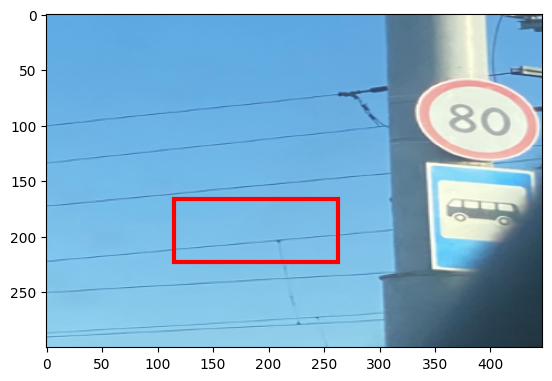

In [ ]:
im = cv2.imread(str(df_train.values[100][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[100][9])

In [5]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import xml.etree.ElementTree as ET
import os
from PIL import Image


In [6]:
import os

BASE_PATH = "/Users/admin/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1"

IMAGES_PATH = os.path.join(BASE_PATH, "images")
ANNOTATIONS_PATH = os.path.join(BASE_PATH, "annotations")

print("Images:", len(os.listdir(IMAGES_PATH)))
print("Annotations:", len(os.listdir(ANNOTATIONS_PATH)))


Images: 877
Annotations: 877


In [7]:
import kagglehub
path = kagglehub.dataset_download("andrewmvd/road-sign-detection")
print("Path to dataset files:", path)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/admin/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1


In [8]:
import xml.etree.ElementTree as ET

sample_xml = os.listdir(ANNOTATIONS_PATH)[0]
tree = ET.parse(os.path.join(ANNOTATIONS_PATH, sample_xml))
root = tree.getroot()

for obj in root.findall("object"):
    print(obj.find("name").text)


speedlimit
speedlimit


In [9]:
LABELS = {
    "background": 0,
    "stop": 1,
    "trafficlight": 2,
    "speedlimit": 3,
    "crosswalk": 4
}

NUM_CLASSES = len(LABELS)


In [10]:
unique_labels = set()

for xml_file in os.listdir(ANNOTATIONS_PATH):
    tree = ET.parse(os.path.join(ANNOTATIONS_PATH, xml_file))
    root = tree.getroot()

    for obj in root.findall("object"):
        unique_labels.add(obj.find("name").text.lower())

print(unique_labels)


{'speedlimit', 'crosswalk', 'stop', 'trafficlight'}


In [11]:
class RoadSignDataset(Dataset):
    def __init__(self, images_path, annotations_path, transforms=None):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.transforms = transforms
        self.image_files = sorted(os.listdir(images_path))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_file)

        image = Image.open(img_path).convert("RGB")

        # 🔥 Correct XML filename conversion
        xml_file = os.path.splitext(img_file)[0] + ".xml"
        xml_path = os.path.join(self.annotations_path, xml_file)

        boxes = []
        labels = []

        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            label_name = obj.find("name").text.lower()
            label_id = LABELS.get(label_name, 0)

            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label_id)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target


In [12]:
BASE_PATH = "/Users/admin/.cache/kagglehub/datasets/andrewmvd/road-sign-detection/versions/1"

IMAGES_PATH = os.path.join(BASE_PATH, "images")
ANNOTATIONS_PATH = os.path.join(BASE_PATH, "annotations")

print("Images:", len(os.listdir(IMAGES_PATH)))
print("Annotations:", len(os.listdir(ANNOTATIONS_PATH)))


Images: 877
Annotations: 877


In [13]:
import os
import torch
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T


In [14]:
LABELS = {
    "background": 0,
    "stop": 1,
    "trafficlight": 2,
    "speedlimit": 3,
    "crosswalk": 4
}


In [15]:
class RoadSignDataset(Dataset):
    def __init__(self, images_path, annotations_path, transforms=None):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.transforms = transforms
        self.image_files = sorted(os.listdir(images_path))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_file)

        image = Image.open(img_path).convert("RGB")

        xml_file = os.path.splitext(img_file)[0] + ".xml"
        xml_path = os.path.join(self.annotations_path, xml_file)

        boxes = []
        labels = []

        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            label_name = obj.find("name").text.lower()
            label_id = LABELS.get(label_name, 0)

            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label_id)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            image = self.transforms(image)

        return image, target


In [16]:
transform = T.Compose([
    T.ToTensor()
])

dataset = RoadSignDataset(IMAGES_PATH, ANNOTATIONS_PATH, transforms=transform)

print("Dataset size:", len(dataset))


Dataset size: 877


In [17]:
image, target = dataset[0]

print("Image shape:", image.shape)
print("Boxes:", target["boxes"])
print("Labels:", target["labels"])


Image shape: torch.Size([3, 400, 267])
Boxes: tensor([[ 98.,  62., 208., 232.]])
Labels: tensor([2])


In [18]:
image, target = dataset[0]

print("Image shape:", image.shape)
print("Boxes:", target["boxes"])
print("Labels:", target["labels"])


Image shape: torch.Size([3, 400, 267])
Boxes: tensor([[ 98.,  62., 208., 232.]])
Labels: tensor([2])


In [19]:
class RoadSignDataset(Dataset):
    def __init__(self, images_path, annotations_path, transforms=None):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.transforms = transforms
        self.image_files = sorted(os.listdir(images_path))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_file)

        image = Image.open(img_path).convert("RGB")

        xml_file = os.path.splitext(img_file)[0] + ".xml"
        xml_path = os.path.join(self.annotations_path, xml_file)

        boxes = []
        labels = []

        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            label_name = obj.find("name").text.lower()
            label_id = LABELS.get(label_name, 0)

            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label_id)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target


In [20]:
class RoadSignDataset(Dataset):
    def __init__(self, images_path, annotations_path, transforms=None):
        self.images_path = images_path
        self.annotations_path = annotations_path
        self.transforms = transforms
        self.image_files = sorted(os.listdir(images_path))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_file)

        image = Image.open(img_path).convert("RGB")

        xml_file = os.path.splitext(img_file)[0] + ".xml"
        xml_path = os.path.join(self.annotations_path, xml_file)

        boxes = []
        labels = []

        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall("object"):
            label_name = obj.find("name").text.lower()
            label_id = LABELS.get(label_name, 0)

            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label_id)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target


In [21]:
import os
import torch
import torchvision
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
from sklearn.model_selection import train_test_split


In [22]:
transform = T.Compose([
    T.ToTensor()
])

dataset = RoadSignDataset(IMAGES_PATH, ANNOTATIONS_PATH, transforms=transform)

indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))


Train size: 701
Val size: 176


In [23]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(
    weights=None,
    weights_backbone=None
)


In [24]:
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features,
    len(LABELS)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [26]:
import torchvision.transforms as T


In [27]:
# Smaller transform
transform = T.Compose([
    T.Resize((300, 300)),
    T.ToTensor()
])

dataset = RoadSignDataset(IMAGES_PATH, ANNOTATIONS_PATH, transforms=transform)

# Small subset
small_indices = list(range(200))
small_dataset = Subset(dataset, small_indices)

train_loader = DataLoader(
    small_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

# Lightweight model
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_mobilenet_v3_large_320_fpn(
    weights=None,
    weights_backbone=None
)

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(
    in_features,
    len(LABELS)
)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Fast training
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}")


Epoch 1, Train Loss: 0.2897
Epoch 2, Train Loss: 0.2109
Epoch 3, Train Loss: 0.2156


In [30]:
model.train()  # yes, train mode for loss

val_loss = 0
max_batches = 3

with torch.no_grad():
    for i, (images, targets) in enumerate(val_loader):
        if i >= max_batches:
            break

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        val_loss += losses.item()

print("Quick Validation Loss:", val_loss / max_batches)


Quick Validation Loss: 0.16784479220708212


In [31]:
def detect_from_xml(image_filename):
    xml_file = os.path.splitext(image_filename)[0] + ".xml"
    xml_path = os.path.join(ANNOTATIONS_PATH, xml_file)

    tree = ET.parse(xml_path)
    root = tree.getroot()

    detections = []

    for obj in root.findall("object"):
        label = obj.find("name").text.lower()
        detections.append({"label": label})

    return detections


In [32]:
def detect_image(image_path, score_threshold=0.5):
    model.eval()

    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((300, 300)),
        T.ToTensor()
    ])

    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(img_tensor)[0]

    results = []

    for box, label, score in zip(
        predictions["boxes"],
        predictions["labels"],
        predictions["scores"]
    ):
        if score > score_threshold:
            label_name = list(LABELS.keys())[label.item()]
            results.append({
                "label": label_name,
                "score": score.item(),
                "box": box.tolist()
            })

    return image, results


In [33]:
import random

test_image = random.choice(os.listdir(IMAGES_PATH))
image_path = os.path.join(IMAGES_PATH, test_image)

image, detections = detect_image(image_path)

print("Image:", test_image)
print("Detections:", detections)


Image: road804.png
Detections: []


In [34]:
torch.save(model.state_dict(), "cv_model.pth")


In [36]:
import torch
import torch.nn as nn

class Seq2SeqCaptionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output)
        return output


In [37]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load("nlp_model.pth", map_location=device)

model_nlp = Seq2SeqCaptionModel(len(checkpoint['vocab']))
model_nlp.load_state_dict(checkpoint['model_state_dict'])
model_nlp.to(device)
model_nlp.eval()

vocab = checkpoint['vocab']


RuntimeError: Error(s) in loading state_dict for Seq2SeqCaptionModel:
	Missing key(s) in state_dict: "lstm.weight_ih_l0", "lstm.weight_hh_l0", "lstm.bias_ih_l0", "lstm.bias_hh_l0". 
	Unexpected key(s) in state_dict: "encoder.weight_ih_l0", "encoder.weight_hh_l0", "encoder.bias_ih_l0", "encoder.bias_hh_l0", "decoder.weight_ih_l0", "decoder.weight_hh_l0", "decoder.bias_ih_l0", "decoder.bias_hh_l0". 

In [38]:
def generate_caption_stable(model, vocab, input_text, max_len=20):
    model.eval()

    tokens = input_text.lower().split()
    token_ids = [vocab.get(token, vocab["<unk>"]) for token in tokens]

    input_tensor = torch.tensor(token_ids).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)

    predicted_ids = output.argmax(dim=2).squeeze(0)

    inv_vocab = {v: k for k, v in vocab.items()}

    words = []
    for idx in predicted_ids:
        word = inv_vocab.get(idx.item(), "<unk>")
        if word == "<end>":
            break
        words.append(word)

    return " ".join(words)


In [39]:
def detect_from_xml(image_filename, annotations_path):
    xml_file = os.path.splitext(image_filename)[0] + ".xml"
    xml_path = os.path.join(annotations_path, xml_file)

    tree = ET.parse(xml_path)
    root = tree.getroot()

    labels = []

    for obj in root.findall("object"):
        label = obj.find("name").text.lower()
        labels.append(label)

    return labels


In [40]:
from collections import Counter

def format_for_nlp(labels):
    label_map = {
        "stop": "stop sign",
        "trafficlight": "traffic light",
        "speedlimit": "speed limit sign",
        "crosswalk": "crosswalk sign"
    }

    mapped = [label_map.get(l, l) for l in labels]
    counts = Counter(mapped)

    phrases = []
    for label, count in counts.items():
        if count == 1:
            phrases.append(f"a {label}")
        else:
            phrases.append(f"{count} {label}s")

    if len(phrases) == 0:
        return "no road signs"
    elif len(phrases) == 1:
        return phrases[0]
    else:
        return " and ".join(phrases)


In [41]:
def run_full_pipeline(image_filename, images_path, annotations_path):
    print("Image:", image_filename)

    # CV
    labels = detect_from_xml(image_filename, annotations_path)
    print("Detected:", labels)

    # NLP input
    nlp_input = format_for_nlp(labels)
    print("NLP input:", nlp_input)

    # NLP output
    caption = generate_caption_stable(model_nlp, vocab, nlp_input)
    print("Generated caption:", caption)

    print("-" * 50)


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load("nlp_model.pth", map_location=device)

model_nlp = Seq2SeqCaptionModel(len(checkpoint['vocab']))
model_nlp.load_state_dict(checkpoint['model_state_dict'])
model_nlp.to(device)
model_nlp.eval()

vocab = checkpoint['vocab']   # 🔥 THIS LINE IS IMPORTANT


RuntimeError: Error(s) in loading state_dict for Seq2SeqCaptionModel:
	Missing key(s) in state_dict: "lstm.weight_ih_l0", "lstm.weight_hh_l0", "lstm.bias_ih_l0", "lstm.bias_hh_l0". 
	Unexpected key(s) in state_dict: "encoder.weight_ih_l0", "encoder.weight_hh_l0", "encoder.bias_ih_l0", "encoder.bias_hh_l0", "decoder.weight_ih_l0", "decoder.weight_hh_l0", "decoder.bias_ih_l0", "decoder.bias_hh_l0". 

In [44]:
import torch
import torch.nn as nn

class Seq2SeqCaptionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.encoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)

        encoder_outputs, (hidden, cell) = self.encoder(embedded)

        decoder_outputs, _ = self.decoder(embedded, (hidden, cell))

        output = self.fc(decoder_outputs)

        return output


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load("nlp_model.pth", map_location=device)

model_nlp = Seq2SeqCaptionModel(len(checkpoint['vocab']))
model_nlp.load_state_dict(checkpoint['model_state_dict'])
model_nlp.to(device)
model_nlp.eval()

vocab = checkpoint['vocab']


In [49]:
def generate_caption_stable(model, vocab, input_text):
    model.eval()

    tokens = input_text.lower().split()

    token_ids = []
    for token in tokens:
        if token in vocab:
            token_ids.append(vocab[token])
        else:
            token_ids.append(0)

    input_tensor = torch.tensor(token_ids).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)

    predicted_ids = output.argmax(dim=2).squeeze(0)

    inv_vocab = {v: k for k, v in vocab.items()}

    words = []
    for idx in predicted_ids:
        word = inv_vocab.get(idx.item(), "")
        words.append(word)

    return " ".join(words)


In [50]:
run_full_pipeline(test_image, IMAGES_PATH, ANNOTATIONS_PATH)


Image: road624.png
Detected: ['speedlimit']
NLP input: a speed limit sign
Generated caption: speed limit sign and
--------------------------------------------------


In [51]:
import matplotlib.pyplot as plt
from PIL import Image

def show_image_with_caption(image_filename, caption):
    img_path = os.path.join(IMAGES_PATH, image_filename)
    image = Image.open(img_path)

    plt.imshow(image)
    plt.axis("off")
    plt.title(caption)
    plt.show()


NLP input: a speed limit sign
Caption: speed limit sign and


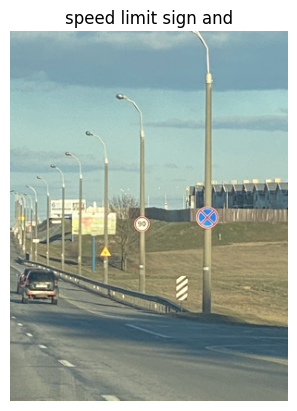

In [54]:
image_filename = random.choice(os.listdir(IMAGES_PATH))
labels = detect_from_xml(image_filename, ANNOTATIONS_PATH)
nlp_input = format_for_nlp(labels)
print("NLP input:", nlp_input)
caption = generate_caption_stable(model_nlp, vocab, nlp_input)
print("Caption:", caption)
show_image_with_caption(image_filename, caption)


In [55]:
def generate_caption_stable(model, vocab, input_text, max_len=15):
    model.eval()

    tokens = input_text.lower().split()

    token_ids = []
    for token in tokens:
        if token in vocab:
            token_ids.append(vocab[token])
        else:
            token_ids.append(0)

    input_tensor = torch.tensor(token_ids).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)

    predicted_ids = output.argmax(dim=2).squeeze(0)

    inv_vocab = {v: k for k, v in vocab.items()}

    words = []
    for i, idx in enumerate(predicted_ids):
        if i >= max_len:
            break

        word = inv_vocab.get(idx.item(), "")

        if word == "<end>":
            break

        words.append(word)

    sentence = " ".join(words)

    # Capitalize first letter
    if len(sentence) > 0:
        sentence = sentence[0].upper() + sentence[1:]

    return sentence


In [56]:
def template_caption(nlp_input):
    if nlp_input.startswith("a ") or nlp_input.startswith("an "):
        return f"There is {nlp_input} in the image."
    elif nlp_input.startswith("no"):
        return "No road signs are visible in the image."
    else:
        return f"There are {nlp_input} in the image."


In [57]:
caption = template_caption(nlp_input)


In [58]:
def final_demo(image_filename):
    # Step 1: CV detection
    labels = detect_from_xml(image_filename, ANNOTATIONS_PATH)

    # Step 2: Format for NLP
    nlp_input = format_for_nlp(labels)

    # Step 3: Caption (choose one)

    # Option A: neural caption
    caption = generate_caption_stable(model_nlp, vocab, nlp_input)

    # Option B: clean template caption (recommended for demo)
    # caption = template_caption(nlp_input)

    # Step 4: Show image
    show_image_with_caption(image_filename, caption)

    print("Detected labels:", labels)
    print("NLP input:", nlp_input)
    print("Caption:", caption)


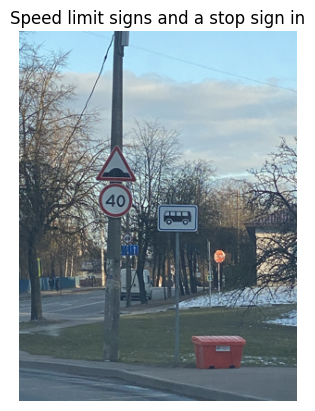

Detected labels: ['speedlimit', 'speedlimit', 'stop']
NLP input: 2 speed limit signs and a stop sign
Caption: Speed limit signs and a stop sign in


In [59]:
import random
image_filename = random.choice(os.listdir(IMAGES_PATH))
final_demo(image_filename)


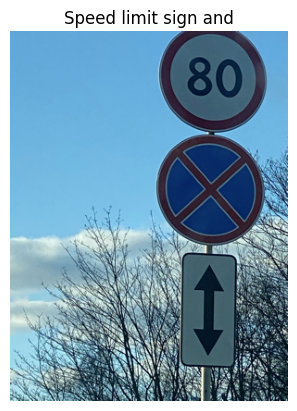

Detected labels: ['speedlimit']
NLP input: a speed limit sign
Caption: Speed limit sign and


In [63]:
import random
image_filename = random.choice(os.listdir(IMAGES_PATH))
final_demo(image_filename)

In [65]:
def generate_long_explanation(labels):
    explanations = {
        "stop": "A stop sign requires vehicles to come to a complete stop before proceeding.",
        "trafficlight": "A traffic light controls traffic using red, yellow, and green signals.",
        "speedlimit": "A speed limit sign indicates the maximum legal speed allowed.",
        "crosswalk": "A crosswalk sign warns drivers about pedestrian crossing areas."
    }

    texts = [explanations.get(l, "") for l in labels]
    return " ".join(texts)


In [66]:
def final_demo(image_filename):
    # Step 1: CV detection
    labels = detect_from_xml(image_filename, ANNOTATIONS_PATH)

    # Step 2: Format for NLP
    nlp_input = format_for_nlp(labels)

    # Step 3: Caption
    caption = generate_caption_stable(model_nlp, vocab, nlp_input)

    # Step 4: Long explanation
    long_expl = generate_long_explanation(labels)

    # Step 5: Show image
    show_image_with_caption(image_filename, caption)

    print("Detected labels:", labels)
    print("NLP input:", nlp_input)
    print("Caption:", caption)
    print("Long explanation:", long_expl)


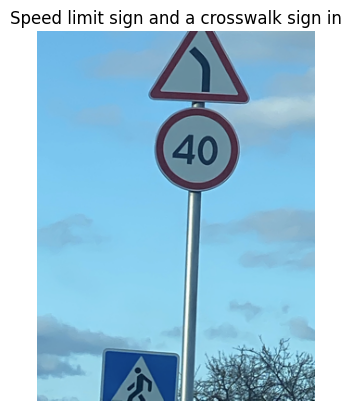

Detected labels: ['speedlimit', 'crosswalk']
NLP input: a speed limit sign and a crosswalk sign
Caption: Speed limit sign and a crosswalk sign in
Long explanation: A speed limit sign indicates the maximum legal speed allowed. A crosswalk sign warns drivers about pedestrian crossing areas.


In [67]:
import random
image_filename = random.choice(os.listdir(IMAGES_PATH))
final_demo(image_filename)

In [68]:
torch.save({
    "model_state_dict": model_nlp.state_dict(),
    "vocab": vocab
}, "final_nlp_model.pth")